In [234]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook, test_value, test_sink

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
n_layers = 7
n_heads = 4
run_path_server = "/data/tianyu_guo/birth/gens/pre-iclr/multi-head/dormant_copy_k3_bos1"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=n_layers, n_heads=n_heads, bos_num=1, train_steps=10000, delim=0, with_data=True, model_name=None, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
model.cuda()
x, y = x.cuda(), y.cuda()
predicts, outputs_list = model.modified_forward_with_hook(x, hook)

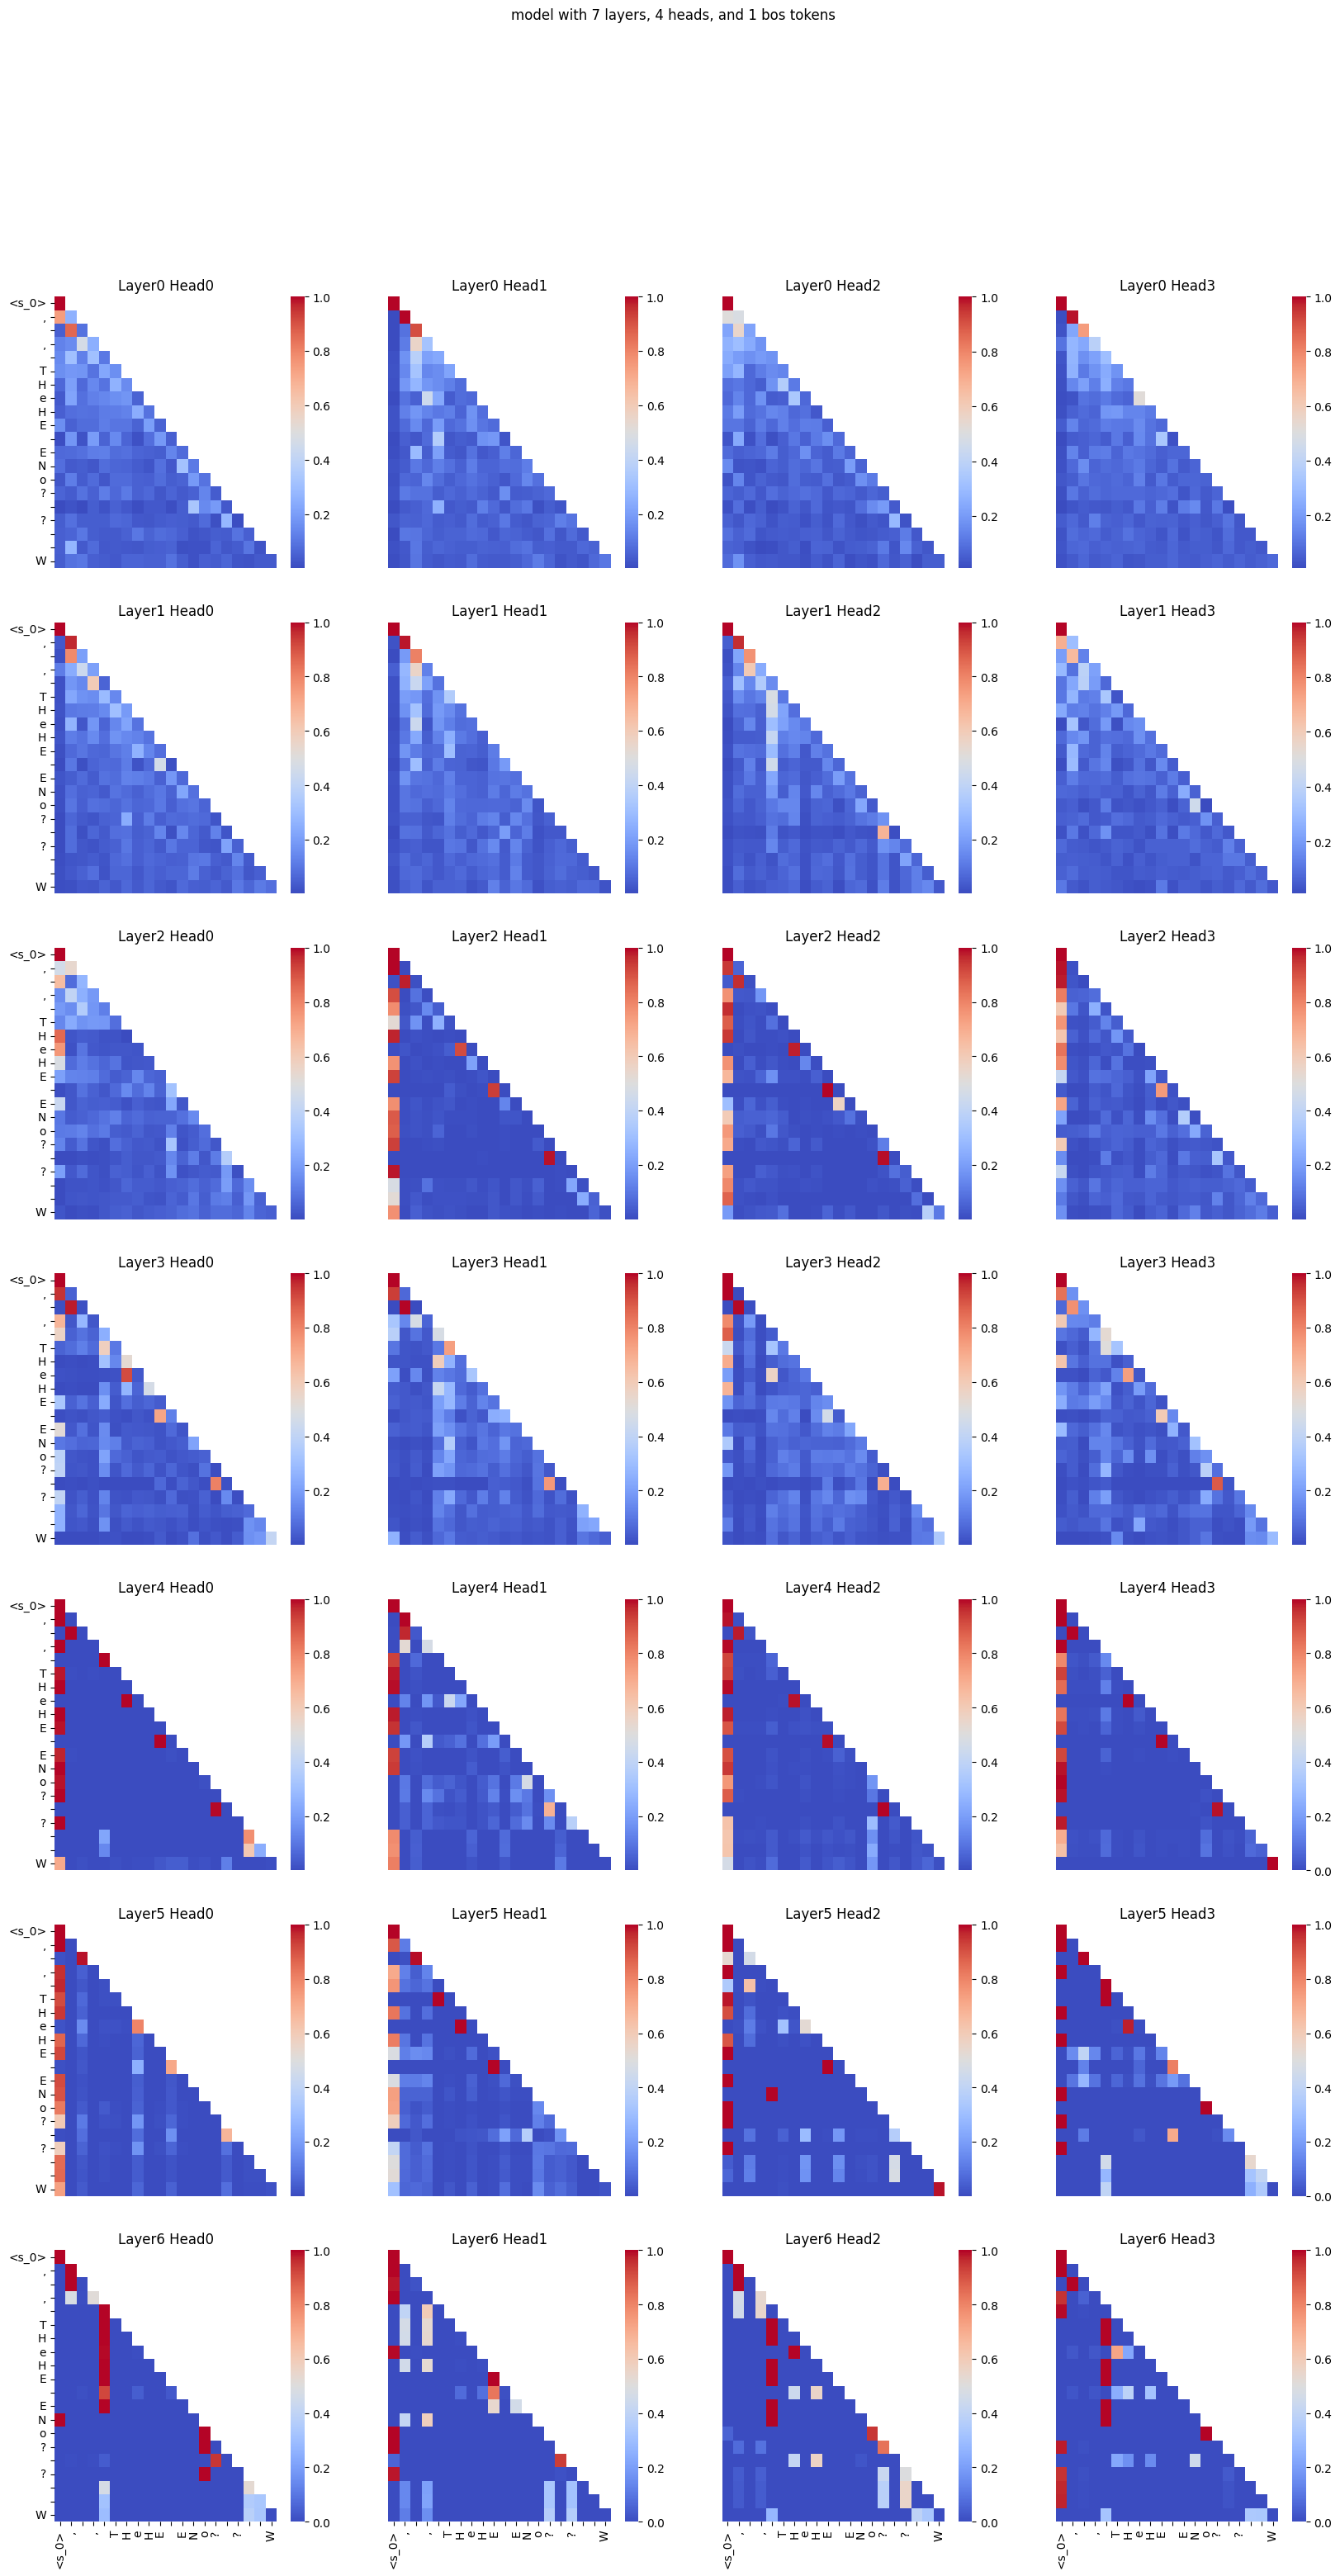

In [236]:
# scores = data['scores'][layer_idx]
seq_len = 20
seq_idx = 0
text = ds.decode(x[seq_idx, :seq_len].cpu().numpy())

fig, axes = plt.subplots(cfg.model_args['n_layers'], cfg.model_args['n_heads'], figsize=(cfg.model_args['n_heads']*5, cfg.model_args['n_layers']*5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    layer_idx = i // cfg.model_args['n_heads']
    head_idx = i % cfg.model_args['n_heads']
    attns = outputs_list[layer_idx]['attn_weights'][seq_idx, head_idx, :seq_len, :seq_len].cpu().detach().numpy()
    # attns = scores[0, i, :20, :20]
    mask = 1 - np.tril(np.ones_like(attns)) # manually impose causal mask for better-looking plots
    if head_idx == 0:
        yticklabels = text
    else:
        yticklabels = False
    if layer_idx == cfg.model_args['n_layers'] - 1:
        xticklabels = text
    else:
        xticklabels = False
    sns.heatmap(
            attns, mask=mask,
            cmap="coolwarm", xticklabels=xticklabels, yticklabels=yticklabels,
            ax=ax,
        )
    ax.set_title(f"Layer{layer_idx} Head{head_idx}")
    # ax.set_xticks(list(ds.decode(x[seq_idx, :20].numpy())))
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

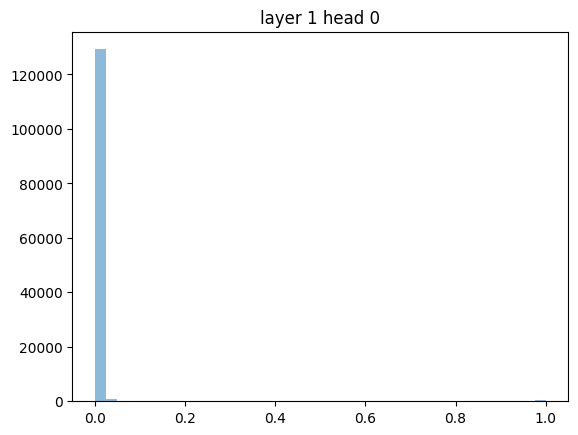

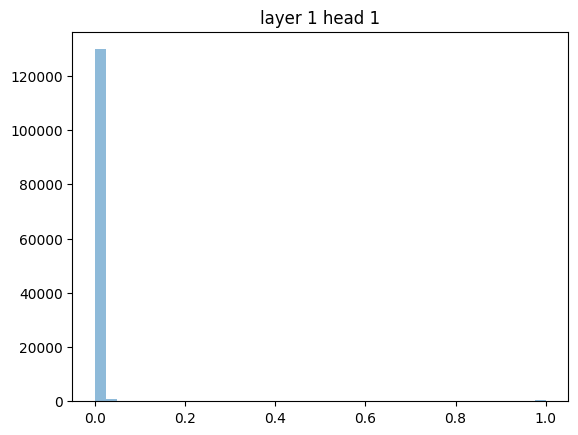

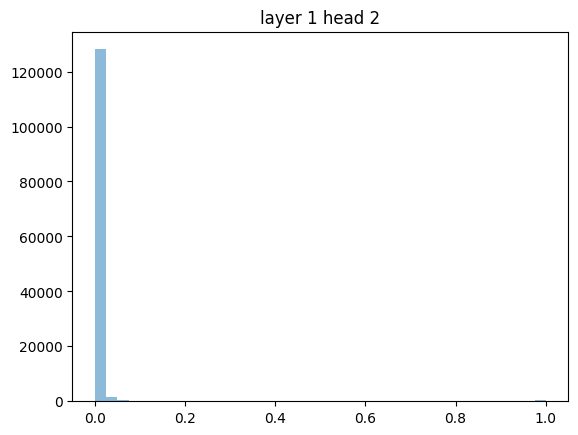

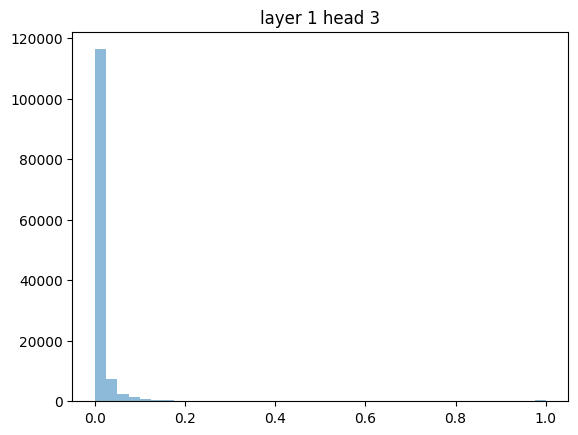

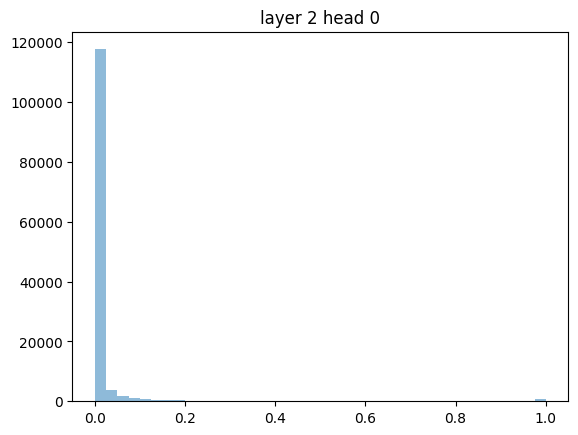

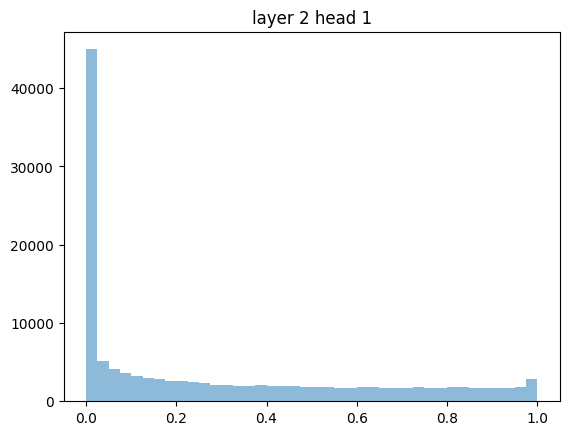

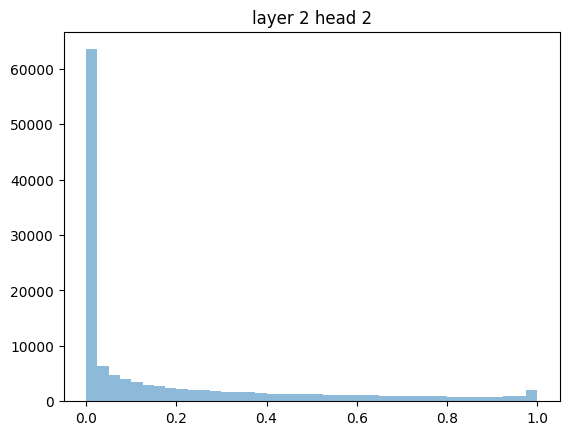

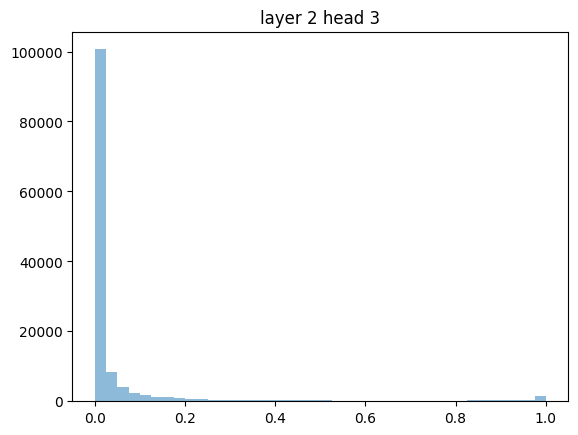

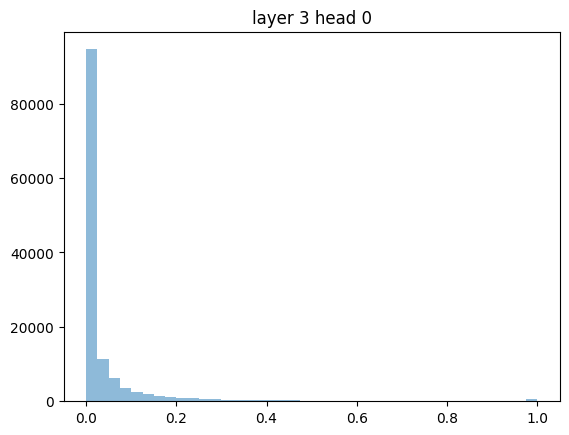

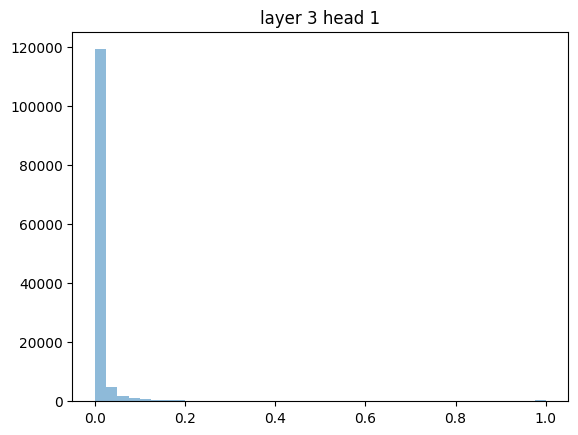

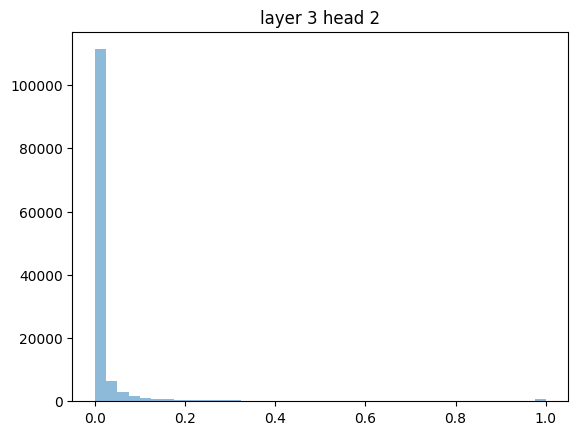

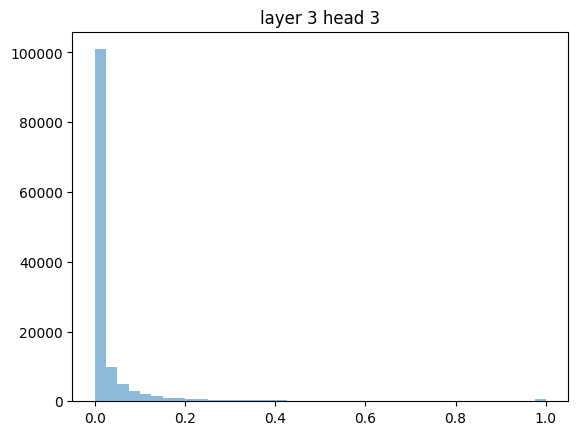

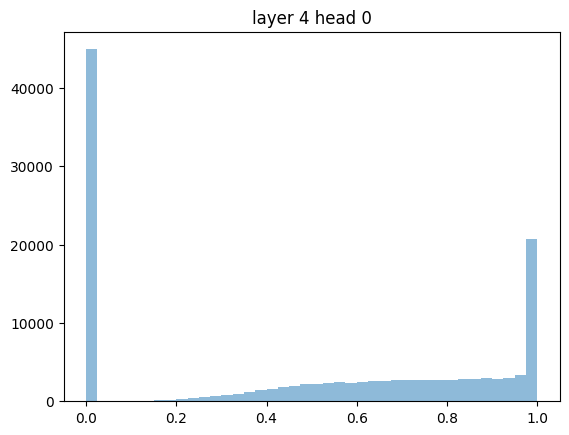

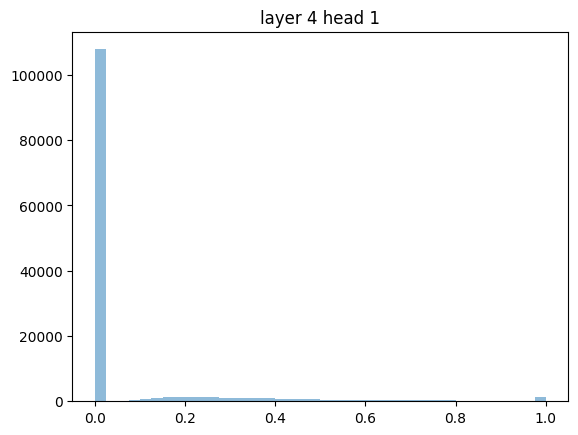

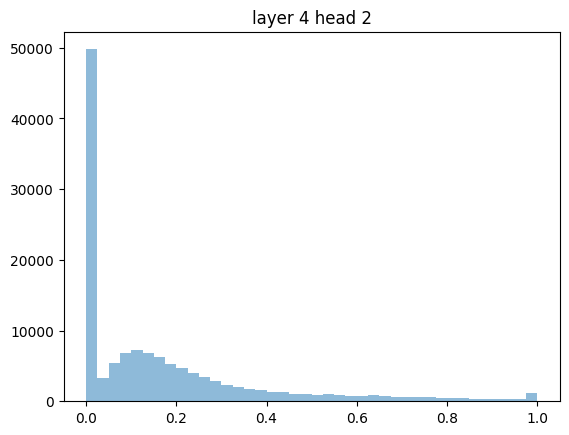

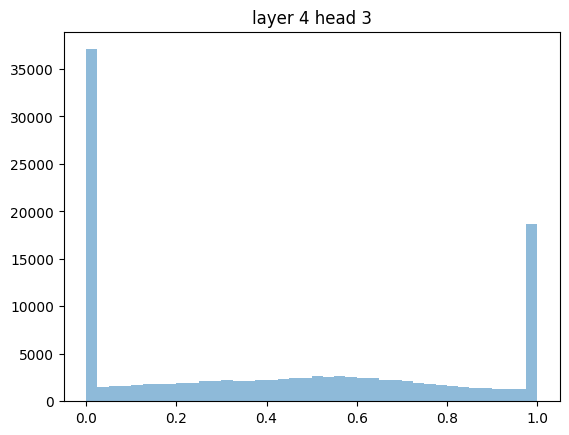

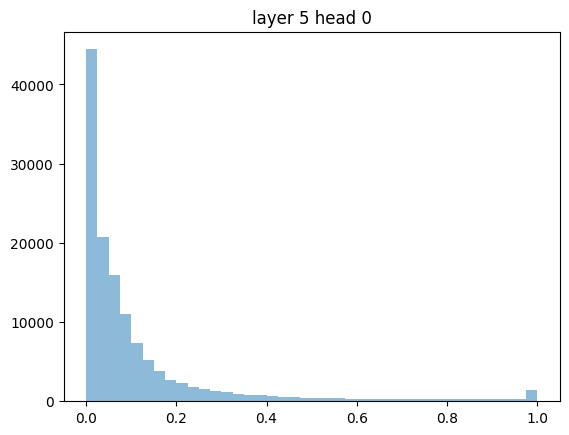

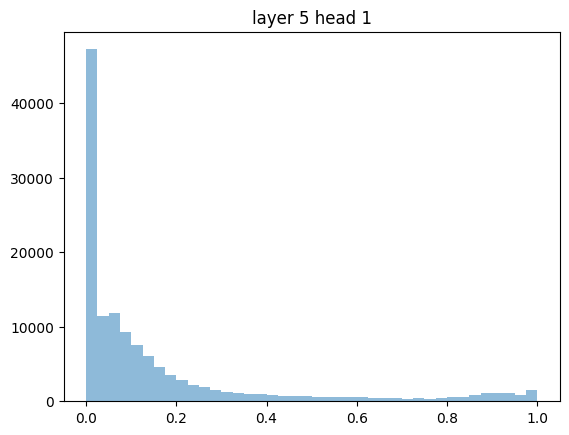

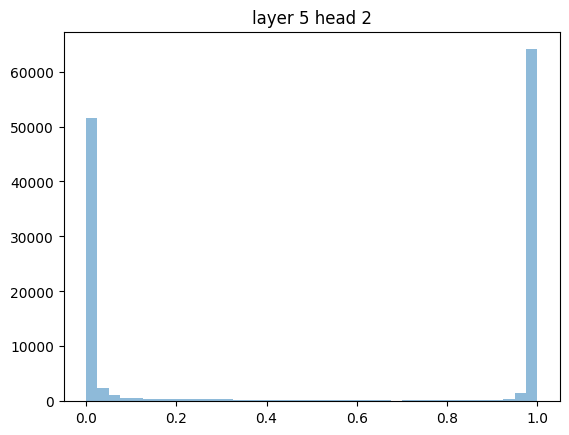

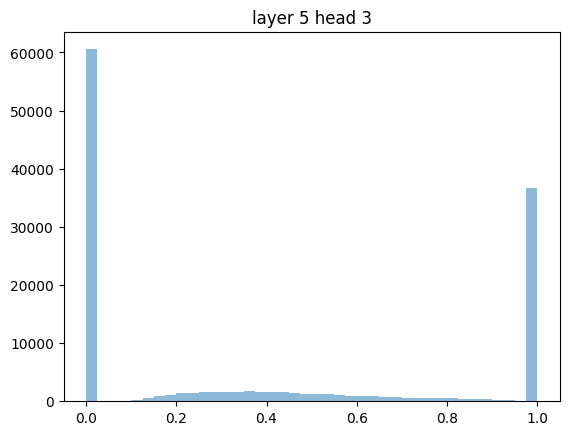

: 

: 

: 

: 

: 

In [238]:
def get_dormant_metric(attn):
    return attn[:, :, 0]
dormants = {}
for layer_idx in range(cfg.model_args['n_layers']):
    for head_idx in range(cfg.model_args['n_heads']):
        dormants[(layer_idx, head_idx)] = get_dormant_metric(outputs_list[layer_idx]['attn_weights'][:, head_idx, ...].cpu().detach())
for layer_idx in range(1, cfg.model_args['n_layers']-1):
    for head_idx in range(4):
        idx = (layer_idx, head_idx)
        plt.hist(dormants[idx].flatten(), bins=40, alpha=0.5, label=idx)
        plt.title(f"layer {layer_idx} head {head_idx}")
        plt.show()